In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix, classification_report

#### Read file

In [3]:
df = pd.read_json('data/electronics_final.json', lines=True)
df = df[df.product_category == 'Electronics']
df = df[df.total_votes > 5]

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase
0,51005725,70,Electronics,B00001W0DC,"First, a direct product link for the MDR-V150:...",2008-06-17,R5M7VQVV19FAQ,1,75,N


#### Add useful columns

In [4]:
df = df.dropna()
df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)

df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]
df.head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
0,51005725,70,Electronics,B00001W0DC,"First, a direct product link for the MDR-V150:...",2008-06-17,R5M7VQVV19FAQ,1,75,N,0.93,True,1600


#### Stats

In [5]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
21070

helpful count
13674

not helpful count
7396

average helpfulness
0.7819501661129379

average length of helpful review
1169.928038613427

average length of not helpful review
796.5996484586262


# Analyse factors vs helpfulness

#### Review length

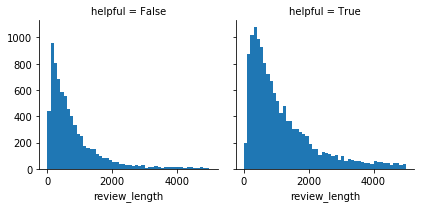

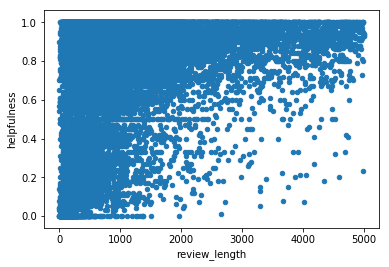

In [6]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'review_length', bins=50)

df.plot.scatter(x='review_length',y='helpfulness')

#### Star rating

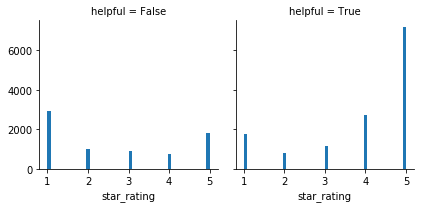

In [6]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'star_rating', bins=50)

#### Review Date

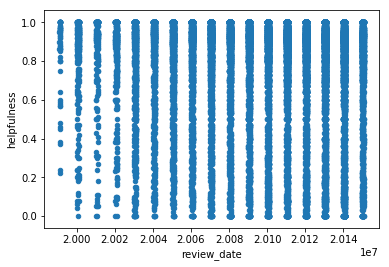

In [8]:
df['review_date'] = pd.to_datetime(df["review_date"]).dt.strftime("%Y%m%d").astype(int)
df.plot.scatter(x='review_date',y='helpfulness')

#### Verified purchase

In [7]:
ver = df[df.verified_purchase == 'Y']
not_ver = df[df.verified_purchase == 'N']

print("avg helpfulness of verified purchases: {0}".format(ver.helpfulness.mean()))
print("avg helpfulness of unverified purchases: {0}".format(not_ver.helpfulness.mean()))

avg helpfulness of verified purchases: 0.7913079183955624
avg helpfulness of unverified purchases: 0.77055777731003


# Predicting using Naive Bayes

In [9]:
X = df['review_body']
Y = df['helpful']

In [10]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [11]:
X = bow_transformer.transform(X)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

### MultinomialNB

In [13]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 722 1452]
 [ 472 3675]]


              precision    recall  f1-score   support

       False       0.60      0.33      0.43      2174
        True       0.72      0.89      0.79      4147

   micro avg       0.70      0.70      0.70      6321
   macro avg       0.66      0.61      0.61      6321
weighted avg       0.68      0.70      0.67      6321



#### Manual examination

In [17]:
df[df.helpfulness > 0.1].sort_values('helpfulness').head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
1897,22817040,4,Electronics,B004X4L1UC,"The glasses is probably OK, but they didn`t wo...",2011-07-25,R59LGUZNZU4QT,1,35,Y,0.11,False,161


In [18]:
mid_review = df['review_body'][2808]
mid_review_transformed = bow_transformer.transform([mid_review])
print("predicted helpful: {0}, actual helpfulness: {1}".format(nb.predict(mid_review_transformed)[0],df['helpfulness'][2808]))

predicted helpful: True, actual helpfulness: 0.93


#### Popular products

In [19]:
df.product_id.value_counts(ascending=False).head(6)

B00007EPJ6    90
B00C404VC2    70
B00C402ZYS    64
B00H6A35X6    64
B000JVGWJI    60
B0001BRITE    58
Name: product_id, dtype: int64

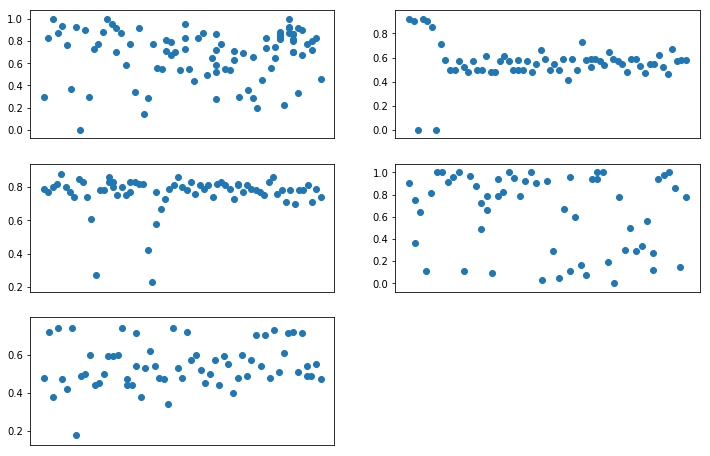

In [21]:
df_1 = df[df.product_id == 'B00007EPJ6']
df_2 = df[df.product_id == 'B00C404VC2']
df_3 = df[df.product_id == 'B00C402ZYS']
df_4 = df[df.product_id == 'B00H6A35X6']
df_5 = df[df.product_id == 'B000JVGWJI']
df_6 = df[df.product_id == 'B0001BRITE']

gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (2, 0))
ax4 = plt.subplot2grid(gridsize, (0, 1))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 1))

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_xticks([])

sctr = ax1.scatter(x = df_1.review_date, y = df_1.helpfulness)
sctr = ax2.scatter(x = df_2.review_date, y = df_2.helpfulness)
sctr = ax3.scatter(x = df_3.review_date, y = df_3.helpfulness)
sctr = ax4.scatter(x = df_4.review_date, y = df_4.helpfulness)
sctr = ax5.scatter(x = df_5.review_date, y = df_5.helpfulness)
sctr = ax6.scatter(x = df_6.review_date, y = df_6.helpfulness)